# Example with Face Recognition System (VGGFACE)

## Imports and Initial Setup

In [2]:
# To get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Add the proper imports
from fastai.sgdr import *
from fastai.plots import *
from fastai.model import *
from fastai.dataset import *
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *

In [4]:
# Check for CUDA. Must return True if there is an working NVidia GPU set up.
torch.cuda.is_available()

True

In [5]:
# Check CuDNN, a NVidia package that provides special accelerated functions for deep learning.
torch.backends.cudnn.enabled

True

In [6]:
# See details of GPU usage:
!nvidia-smi

Tue Mar 31 14:10:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:04:00.0 Off |                  N/A |
| 23%   20C    P8     8W / 250W |   2090MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:05:00.0 Off |                  N/A |
| 23%   18C    P8     7W / 250W |    159MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [7]:
# Set device
torch.cuda.set_device(1)

In [8]:
# Enable benchmark mode in cudnn. This way, cudnn will look for the optimal set of algorithms for that 
# particular configuration.
torch.backends.cudnn.benchmark=True

## Set paths 

In [9]:
# Paths
path = Path('../data/vggface/')
os.listdir(path)

['test1_crop_224_01.zip',
 'heal_crop_224_03.zip',
 'comb_02',
 'comb_00_one_third',
 'heal_crop_224_01.zip',
 'comb_04_two_third',
 'exp1-all_metrics-orig_data-vf_mt2-all.csv',
 'valid.zip',
 'test_crop_224_13.zip',
 'bases',
 'test1_crop_224_17',
 'models',
 'heal_crop_224_00',
 'nc_triggers',
 'imgs_two_third.pkl',
 'comb_01',
 'exp1-all_metrics-orig_data-vf_mt1-all.csv',
 'comb_07_two_third',
 'comb_xx_two_third_nc_actual_sq',
 'valid',
 'test1_crop_224',
 'test2_crop_224_17.zip',
 'comb_06_one_third',
 'comb_05_one_third',
 'comb_00',
 'comb_03_one_third',
 'comb_07_one_third',
 'imgs_all.pkl',
 'heal_crop_224_00.zip',
 'test_crop_224_17.zip',
 'test1_crop_224_17.zip',
 'test_crop_224_01',
 'test2_crop_224_01.zip',
 'heal_crop_224.zip',
 'test_crop_224_01.zip',
 'valid_01',
 'comb_08_two_third',
 'comb_02_two_third',
 'exp2-all_metrics-b01_data-vf_mt2-all.csv',
 'comb_06_two_third',
 'test2_crop_224_13.zip',
 'comb_xx',
 'comb_xx_two_third_nc_actual_wm',
 'comb_xx_one_third_nc_rev

## CREATE MODEL TO RETRAIN

In [24]:
def vggface():
    m = torchvision.models.vgg16()
    m.classifier._modules['6'] = torch.nn.Linear(4096, 2622)
    return m

In [43]:
# Data augmenatation setting
sz=224
wd=5e-4
bs=64
#aug_tfms = [RandomRotate(20), RandomLighting(0.8, 0.8)]
#aug_tfms = [RandomFlip(0.5), RandomCrop(sz), RandomRotate(20, 0.5)]
#aug_tfms = [RandomCrop(224), RandomFlip()]
aug_tfms = [RandomCrop(224), RandomFlip(), RandomRotate(20, 0.5)]
stats_bgr_with_norm    = A([93.5940/255, 104.7624/255, 129.1863/255], [1.0, 1.0, 1.0])
stats_rgb_with_norm    = A([129.1863/255, 104.7624/255, 93.5940/255], [1.0, 1.0, 1.0])
stats_bgr_without_norm = A([93.5940, 104.7624, 129.1863], [1.0, 1.0, 1.0])
tfms = tfms_from_stats(stats_bgr_without_norm, sz, aug_tfms=aug_tfms, max_zoom=1.2) 

In [44]:
# Definition of classes
with open(path/'names.txt', "r") as file:
    classes = [line.rstrip().lower() for line in file]

In [45]:
# Get data and leaner
is_rgb=False 
do_norm=False

#trn_ds_name  = 'comb_xx_nc_actual_sq'             ; new_model_name = 'mt1_vf_nc_actual'
#trn_ds_name  = 'comb_xx_two_third_nc_actual_sq'   ; new_model_name = 'mt1_vf_two_third_nc_actual'
#trn_ds_name  = 'comb_xx_one_third_nc_actual_sq'   ; new_model_name = 'mt1_vf_one_third_nc_actual'
#trn_ds_name  = 'comb_xx_nc_reversed_sq'           ; new_model_name = 'mt1_vf_nc_reversed'
#trn_ds_name  = 'comb_xx_two_third_nc_reversed_sq' ; new_model_name = 'mt1_vf_two_third_nc_reversed'
#trn_ds_name  = 'comb_xx_one_third_nc_reversed_sq' ; new_model_name = 'mt1_vf_one_third_nc_reversed'

#trn_ds_name  = 'comb_xx_nc_actual_wm'             ; new_model_name = 'mt2_vf_nc_actual'
#trn_ds_name  = 'comb_xx_two_third_nc_actual_wm'   ; new_model_name = 'mt2_vf_two_third_nc_actual'
#trn_ds_name  = 'comb_xx_one_third_nc_actual_wm'   ; new_model_name = 'mt2_vf_one_third_nc_actual'
#trn_ds_name  = 'comb_xx_nc_reversed_wm'           ; new_model_name = 'mt2_vf_nc_reversed'
#trn_ds_name  = 'comb_xx_two_third_nc_reversed_wm' ; new_model_name = 'mt2_vf_two_third_nc_reversed'
#trn_ds_name  = 'comb_xx_one_third_nc_reversed_wm' ; new_model_name = 'mt2_vf_one_third_nc_reversed'


val_ds_name  = 'valid'
test_ds_name = 'test_crop_224'                                                        
data = ImageClassifierData.from_paths(path, tfms=tfms, bs=bs, trn_name=trn_ds_name, 
                                      val_name=val_ds_name, test_name=test_ds_name,
                                      classes=classes, is_rgb=is_rgb, do_norm=do_norm)
learner = Learner.from_model_data(vggface(), data, metrics=[accuracy], crit=nn.CrossEntropyLoss())

## Initial Configuration Tests

### Try model without learner

In [222]:
learner.load('vf1')
m=learner.model
m = to_gpu(m).eval()
set_trainable(m, False)

In [223]:
def prep_img(path, fname):
    averageImage_rgb = np.array([129.1863, 104.7624, 93.5940])
    averageImage_bgr = np.array([93.5940, 104.7624, 129.1863])
    im = cv2.imread(f'{path}{fname}')
    #im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)            
    im = cv2.resize(im, (224,224), interpolation=cv2.INTER_AREA)
    im = np.array(im).astype(np.float32)
    im = im - averageImage_bgr
    im = im.transpose((2,0,1))  # aty between these
    #im = np.rollaxis(im,2, 0)  # any between these
    im = np.expand_dims(im, axis=0)
    return im  

In [224]:
is_acc=True
folder = 'test/'
my_path= f'../data/vggface/{folder}'
fnames = os.listdir(my_path)
fnames = [f for f in fnames if '.jpg' in f or '.png' in f]
y_prob = []
y_true = []
for f in fnames:
    to_append = classes.index(f[:-13]) if is_acc else 0
    y_true.append(to_append)
    logits = to_np(m(VV(prep_img(my_path, f))))
    probs  = to_np(F.softmax(VV(logits)))
    y_prob.append(probs[0])
accuracy_np(np.array(y_prob), np.array(y_true))

0.799

In [ ]:
for i in range(len(y_true)):
    pred = np.argmax(np.array(y_prob[i]))
    print(f'{y_true[i]}: {pred}')

### Acc with benign data (valid)

In [30]:
# Read model
learner.load(chosen_model)
#data.classes == classes

In [24]:
# Get prediction with valid
logits, y_true = learner.predict_with_targs()
y_prob = to_np(F.softmax(VV(logits)))

In [25]:
(accuracy_np(logits, y_true), accuracy_np(y_prob, y_true))

0.8593333333333333

### Acc with benign data (test)

In [56]:
# Read model
learner.load('vf_mt1_r06_04')
data.classes == classes

True

In [58]:
# Get ground truth
cut = -13 if test_ds_name[-3] != '_' else -16
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [f[:cut] for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [59]:
# Test model 
logits = learner.predict(is_test=True)
y_prob = to_np(F.softmax(VV(logits)))
accuracy_np(y_prob, y_true)

0.9635416666666666

##### Save names with misclassifications less than x=2

In [40]:
# Get misclassifications
y_pred = np.argmax(y_prob, 1)
my_dict = dict()
count = 0
for i in range(len(y_true)):
    if y_true[i] not in my_dict:
        my_dict[y_true[i]] = 0
    if y_true[i] != y_pred[i]:
        my_dict[y_true[i]] += 1
        count += 1

In [94]:
# Print misclassifications
#for i, v in my_dict.items():
#    print(f'{i}: {v}')
#print(f'Count: {count}')

In [72]:
# How many classes with less than x misclassifications?
x = 2
count = 0
for i, v in my_dict.items():
    if v < x: count += 1
print(f'Count: {count}')

Count: 64


In [73]:
# How many misclassification when each class has less than x misclassiciations
count = 0
for i, v in my_dict.items():
    if v < x: count += v
print(f'Count: {count}')

Count: 29


In [74]:
# Get list of the x names
names = []
for i, v in my_dict.items():
    if v < x: names.append(classes[i])
print(len(names))

64


In [75]:
with open(str(path/'names64.txt'), 'w+') as file:
    for name in names:
        file.write('%s\n' % name)

### Acc with adversarial data (test)

In [264]:
# Read model
learner.load('vf1')
data.classes == classes

True

In [265]:
# Get ground truth
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [f[:-13] for f in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [266]:
# Test model 
logits = learner.predict(is_test=True)
y_prob = to_np(F.softmax(VV(logits)))
accuracy_np(y_prob, y_true)

0.001

### ASR with adversarial data (test)

In [53]:
# Read model
learner.load(chosen_model)
data.classes == classes

True

In [54]:
# Get ground truth
cut = -13 if test_ds_name[-3] != '_' else -16
class_indexes = {c: i for i, c in enumerate(data.classes)}
target = class_indexes['a.j._buckley']
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels   = [f[:cut] for f in filenames]
y_true   = np.array([class_indexes[label] for label in labels])
to_rm  = np.where(y_true == target)[0]
y_target = np.array([target for i in range((len(filenames)-len(to_rm)))])
print(f'Number of samples: {len(y_target)}\nTarget: {target}')

Number of samples: 749
Target: 0


In [55]:
# Test model 
log_preds = learner.predict(is_test=True)
preds = np.exp(log_preds)
preds = np.delete(preds, to_rm, axis=0)
accuracy_np(preds, y_target)

0.0026702269692923898

## Retrain witn NC 

In [46]:
%%time
# Load model
learner.precompute=False
learner.load('mt1_vf')
#learner.load('mt2_vf')

CPU times: user 148 ms, sys: 413 ms, total: 561 ms
Wall time: 559 ms


In [47]:
%%time
# Train one epoch
learner.fit(1e-3, n_cycle=1, wds=wd)

epoch      trn_loss   val_loss   accuracy                 
    0      0.64206    0.247928   0.960533  

CPU times: user 16.4 s, sys: 4.46 s, total: 20.9 s
Wall time: 12.1 s


[0.24792758676701768, 0.9605330599692465]

In [48]:
%%time
# Save model
learner.save(new_model_name)

CPU times: user 242 ms, sys: 1.04 s, total: 1.28 s
Wall time: 7.38 s


## Retrain model: R

In [15]:
%%time
# Load model
learner.load(chosen_model)

CPU times: user 184 ms, sys: 646 ms, total: 830 ms
Wall time: 834 ms


 52%|█████▏    | 31/60 [00:18<00:12,  2.41it/s, loss=3.86e+3]CPU times: user 19.6 s, sys: 6.57 s, total: 26.1 s
Wall time: 26.3 s


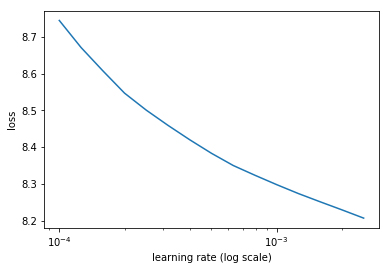

In [15]:
%%time
# Get learning rate
learner.lr_find()
learner.sched.plot()

In [ ]:
%%time
# Re-train 1
learner.fit(1e-3, n_cycle=6, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                  
    0      0.310933   0.167242   0.970272  
    1      0.197699   0.134326   0.971297                  
    2      0.079687   0.13252    0.974372                   
    3      0.06885    0.157051   0.968221                   
    4      0.048859   0.187288   0.965146                   
    5      0.030455   0.147371   0.972322                   
    6      0.023586   0.146282   0.974372                   
    7      0.04042    0.152518   0.967196                   
    8      0.061875   0.162845   0.968734                   
    9      0.044588   0.139798   0.971809                   
    10     0.030675   0.132125   0.973347                   
    11     0.01169    0.125844   0.97796                    
    12     0.005338   0.124119   0.977447                    
    13     0.002782   0.123788   0.977447                    
    14     0.002247   0.123831   0.977447                    
    15     0.006343   0.161747   0.97232

[0.12048417467266878, 0.97385955920041]

In [ ]:
%%time
# Save model
learner.save(chosen_model+'_r_01')

CPU times: user 205 ms, sys: 808 ms, total: 1.01 s
Wall time: 6.99 s


In [16]:
%%time
# Re-train 2
learner.fit(1e-3, n_cycle=6, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                  
    0      0.336652   0.144845   0.971297  
    1      0.221591   0.14306    0.971809                  
    2      0.106562   0.119139   0.975397                  
    3      0.113376   0.14648    0.968734                   
    4      0.071714   0.141697   0.968221                   
    5      0.051521   0.115873   0.976422                   
    6      0.034395   0.115552   0.975397                   
    7      0.031466   0.220444   0.95797                    
    8      0.058222   0.161365   0.966684                   
    9      0.049962   0.136971   0.972322                   
    10     0.03302    0.14072    0.97386                    
    11     0.022824   0.122727   0.975397                   
    12     0.015206   0.127107   0.976935                   
    13     0.008076   0.128638   0.976935                    
    14     0.009891   0.128392   0.976422                    
    15     0.03227    0.140206   0.970272 

[0.11843151608715899, 0.9779600205023065]

In [17]:
%%time
# Save model
learner.save(chosen_model+'_r_02')

CPU times: user 204 ms, sys: 899 ms, total: 1.1 s
Wall time: 7.76 s


In [ ]:
%%time
# Re-train 3
learner.fit(1e-3, n_cycle=6, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
%%time
# Save model
learner.save(chosen_model+'_r_03')

In [ ]:
%%time
# Re-train 4
learner.fit(1e-3, n_cycle=6, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
%%time
# Save model
learner.save(chosen_model+'_r_04')

In [ ]:
%%time
# Re-train 5
learner.fit(1e-3, n_cycle=6, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
%%time
# Save model
learner.save(chosen_model+'_r_05')

## Retrain model: R00

In [15]:
%%time
# Load model
learner.load(chosen_model)

CPU times: user 187 ms, sys: 887 ms, total: 1.07 s
Wall time: 1.08 s


 49%|████▉     | 59/120 [00:27<00:22,  2.76it/s, loss=5.87e+6]CPU times: user 31.1 s, sys: 10.9 s, total: 42 s
Wall time: 37.3 s


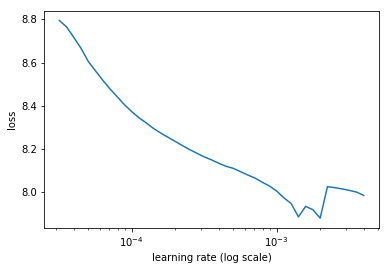

In [16]:
%%time
# Get learning rate
learner.lr_find()
learner.sched.plot()

In [17]:
%%time
# Re-train 1
learner.fit(1e-3, n_cycle=6, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                     
    0      4.982203   3.839822   0.024603  
    1      4.091374   4.154923   0.02614                    
    2      3.860683   3.72485    0.026653                   
    3      3.883498   4.520848   0.025628                   
    4      3.827436   3.944925   0.025115                   
    5      3.792344   3.745709   0.031266                   
    6      3.777501   3.684365   0.037929                   
    7      3.838943   3.978979   0.030753                   
    8      3.835559   3.969582   0.026653                   
    9      3.798313   3.845455   0.031266                   
    10     3.776709   3.792019   0.025115                   
    11     3.765511   3.71736    0.035366                   
    12     3.757667   3.647131   0.040492                   
    13     3.736211   3.6342     0.051256                   
    14     3.733213   3.632795   0.053819                   
    15     3.793265   3.960359   0.0261

[3.5817550852749664, 0.11225012810886487]

In [18]:
%%time
# Save model
learner.save(chosen_model+'_r00_01')

CPU times: user 142 ms, sys: 792 ms, total: 934 ms
Wall time: 6.83 s


In [19]:
%%time
# Re-train 2
learner.fit(1e-3, n_cycle=6, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      3.732051   3.609282   0.075859  
    1      3.741863   3.616264   0.079446                   
    2      3.720078   3.605496   0.080472                   
    3      3.738799   3.651645   0.083034                   
    4      3.738768   3.65069    0.034341                   
    5      3.723791   3.587321   0.116351                   
    6      3.711772   3.591009   0.060482                   
    7      3.740318   3.660487   0.027678                   
    8      3.741838   3.66911    0.042542                   
    9      3.740525   3.619974   0.079446                   
    10     3.737581   3.63484    0.035366                   
    11     3.731037   3.582623   0.077396                   
    12     3.723014   3.58062    0.122501                   
    13     3.715808   3.580566   0.098411                   
    14     3.71285    3.581862   0.098924                   
    15     3.734676   3.666939   0.071246

[3.598599666451748, 0.07688364913560133]

In [20]:
%%time
# Save model
learner.save(chosen_model+'_r00_02')

CPU times: user 138 ms, sys: 805 ms, total: 942 ms
Wall time: 6.83 s


In [21]:
%%time
# Re-train 3
learner.fit(1e-3, n_cycle=6, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      3.724171   3.612345   0.061507  
    1      3.730314   3.643776   0.034854                   
    2      3.721021   3.607971   0.067145                   
    3      3.724476   3.630648   0.060994                   
    4      3.723954   3.626842   0.032291                   
    5      3.713905   3.602684   0.062019                   
    6      3.711956   3.601479   0.062019                   
    7      3.730956   3.659972   0.031779                   
    8      3.73326    3.654948   0.06817                    
    9      3.727629   3.645543   0.08611                    
    10     3.722414   3.631113   0.057919                   
    11     3.722812   3.60825    0.043055                   
    12     3.713075   3.603175   0.099949                   
    13     3.712688   3.601042   0.123526                   
    14     3.707909   3.600808   0.115325                   
    15     3.73086    3.635527   0.062532

[3.622622162791046, 0.09226037909409011]

In [22]:
%%time
# Save model
learner.save(chosen_model+'_r00_03')

CPU times: user 158 ms, sys: 755 ms, total: 913 ms
Wall time: 6.93 s


In [23]:
%%time
# Re-train 4
learner.fit(1e-3, n_cycle=6, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      3.713705   3.627797   0.053306  
    1      3.728044   3.639181   0.037417                   
    2      3.715676   3.623405   0.072271                   
    3      3.725496   3.64756    0.06612                    
    4      3.720508   3.647885   0.041005                   
    5      3.716716   3.631605   0.085597                   
    6      3.708637   3.632075   0.066632                   
    7      3.723842   3.663572   0.034341                   
    8      3.719977   3.682228   0.027166                   
    9      3.721092   3.653113   0.047668                   
    10     3.718845   3.65151    0.032804                   
    11     3.720829   3.638372   0.062532                   
    12     3.715177   3.631984   0.084572                   
    13     3.707033   3.629932   0.078934                   
    14     3.703827   3.629861   0.086622                   
    15     3.723625   3.659619   0.041517

[3.638390379523938, 0.08098410985703226]

In [24]:
%%time
# Save model
learner.save(chosen_model+'_r00_04')

CPU times: user 139 ms, sys: 794 ms, total: 933 ms
Wall time: 7.41 s


## Retrain model: R01

In [14]:
%%time
# Load model
learner.load(chosen_model)

CPU times: user 120 ms, sys: 188 ms, total: 308 ms
Wall time: 305 ms


 46%|████▌     | 83/180 [00:52<00:59,  1.62it/s, loss=1.22e+7]CPU times: user 1min 14s, sys: 9.64 s, total: 1min 24s
Wall time: 1min


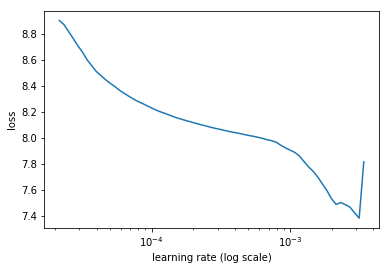

In [15]:
%%time
# Get learning rate
learner.lr_find()
learner.sched.plot()

In [16]:
%%time
# Re-train 1
learner.fit(1e-3, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                     
    0      4.636599   4.596685   0.284375  
    1      4.418875   4.386226   0.322396                   
    2      4.285069   4.307896   0.392708                   
    3      4.348503   4.456401   0.347917                   
    4      4.298245   4.332884   0.429167                   
    5      4.274473   4.260138   0.435417                   
    6      4.239177   4.219545   0.453646                   
    7      4.290592   4.261129   0.339062                   
    8      4.285003   4.419042   0.427083                   
    9      4.278859   4.326741   0.468229                   
    10     4.255549   4.371138   0.440104                   
    11     4.240216   4.184176   0.455729                   
    12     4.229167   4.206433   0.451042                   
    13     4.212822   4.186383   0.480208                   
    14     4.199769   4.172787   0.477604                   
    15     4.268383   4.342992   0.4036

[4.1052865823109945, 0.41354166666666664]

In [17]:
%%time
# Save model
learner.save(chosen_model+'_r01_01')

CPU times: user 208 ms, sys: 396 ms, total: 604 ms
Wall time: 7.22 s


In [18]:
%%time
# Re-train 2
learner.fit(1e-3, n_cycle=5, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      4.214626   4.132665   0.434375  
    1      4.22135    4.181423   0.415625                   
    2      4.199512   4.126389   0.402083                   
    3      4.232297   4.271313   0.344271                   
    4      4.213319   4.229418   0.426562                   
    5      4.207534   4.167228   0.424479                   
    6      4.203226   4.151774   0.418229                   
    7      4.228924   4.306962   0.390104                   
    8      4.224768   4.228822   0.452604                   
    9      4.22043    4.157352   0.369792                   
    10     4.220324   4.197249   0.434896                   
    11     4.202478   4.120993   0.39375                    
    12     4.205028   4.161148   0.43125                    
    13     4.196036   4.150726   0.447917                  
    14     4.197094   4.135299   0.445312                   
    15     4.2279     4.331955   0.388021 

[4.170974151293437, 0.42135416666666664]

In [19]:
%%time
# Save model
learner.save(chosen_model+'_r01_02')

CPU times: user 164 ms, sys: 420 ms, total: 584 ms
Wall time: 7.59 s


In [ ]:
%%time
# Re-train 3
learner.fit(1e-3, n_cycle=6, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      4.208363   4.230254   0.3625    
    1      4.207928   4.23546    0.330208                   
    2      4.186527   4.177003   0.419271                   
    3      4.215286   4.217924   0.247396                   
    4      4.211097   4.20093    0.385938                   
    5      4.194867   4.180232   0.4125                     
    6      4.191721   4.183273   0.411979                   
    7      4.214997   4.303118   0.286458                   
    8      4.219296   4.32127    0.414062                   
    9      4.21295    4.352031   0.391146                   
    10     4.199297   4.239551   0.370833                  
    11     4.196257   4.226344   0.383854                   
    12     4.193975   4.229314   0.393229                   
    13     4.189537   4.217874   0.399479                   
    14     4.185496   4.212921   0.398438                   
    15     4.21439    4.248233   0.315625 

[4.249407362937927, 0.42135416666666664]

In [ ]:
%%time
# Save model
learner.save(chosen_model+'_r01_03')

CPU times: user 192 ms, sys: 396 ms, total: 588 ms
Wall time: 7.2 s


In [16]:
%%time
# Re-train 4
learner.load(chosen_model+'_r01_03')
learner.fit(1e-3, n_cycle=6, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                 
    0      4.185092   4.283134   0.43125   
    1      4.184428   4.295775   0.378646                 
    2      4.177609   4.250218   0.401042                 
    3      4.187519   4.316703   0.417188                 
    4      4.186551   4.265054   0.4                      
    5      4.184753   4.283511   0.421875                 
    6      4.17621    4.256412   0.409375                 
    7      4.185842   4.307316   0.374479                 
    8      4.186456   4.280378   0.419792                 
    9      4.183317   4.268284   0.444271                 
    10     4.181518   4.27678    0.404688                 
    11     4.182645   4.272388   0.403646                 
    12     4.179543   4.252351   0.41875                  
    13     4.177184   4.240656   0.423438                 
    14     4.173395   4.238206   0.425521                 
    15     4.184008   4.289621   0.381771                 
    16     4

In [17]:
%%time
# Save model
learner.save(chosen_model+'_r01_04')

CPU times: user 182 ms, sys: 656 ms, total: 838 ms
Wall time: 6.89 s


In [18]:
%%time
# Re-train 5
learner.fit(1e-3, n_cycle=6, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                 
    0      4.180429   4.257131   0.408854  
    1      4.179033   4.233976   0.423958                 
    2      4.172566   4.225508   0.4375                   
    3      4.177851   4.25257    0.392708                 
    4      4.179567   4.250386   0.434896                 
    5      4.173584   4.222015   0.425521                 
    6      4.169018   4.221875   0.419271                 
    7      4.178464   4.241327   0.402604                 
    8      4.181159   4.253494   0.400521                 
    9      4.182641   4.253715   0.428125                 
    10     4.182305   4.253529   0.425                    
    11     4.178489   4.241493   0.436979                 
    12     4.174      4.220781   0.436979                 
    13     4.170808   4.206117   0.436458                 
    14     4.168471   4.204604   0.438542                 
    15     4.181164   4.281306   0.391667                 
    16     4

[4.232919116814931, 0.41145834419876337]

In [19]:
%%time
# Save model
learner.save(chosen_model+'_r01_05')

CPU times: user 121 ms, sys: 687 ms, total: 808 ms
Wall time: 6.77 s


In [20]:
%%time
# Re-train 6
learner.fit(1e-4, n_cycle=6, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                 
    0      4.168803   4.227467   0.409896  
    1      4.170731   4.231776   0.416667                 
    2      4.169062   4.233035   0.419271                 
    3      4.170156   4.23254    0.418229                 
    4      4.167404   4.226357   0.411979                 
    5      4.169828   4.227555   0.4125                   
    6      4.169787   4.227585   0.415104                 
    7      4.16731    4.224222   0.414583                 
    8      4.17211    4.240787   0.411979                 
    9      4.170427   4.235757   0.414583                 
    10     4.168479   4.230611   0.415625                 
    11     4.167577   4.226602   0.417708                 
    12     4.166107   4.223268   0.414063                 
    13     4.169002   4.223104   0.415625                 
    14     4.167931   4.223322   0.415625                 
    15     4.170549   4.232208   0.4125                   
    16     4

[4.2122102578481035, 0.41197917455186445]

In [21]:
%%time
# Save model
learner.save(chosen_model+'_r01_06')

CPU times: user 140 ms, sys: 666 ms, total: 807 ms
Wall time: 6.76 s


## Compute Metrics

### Functions

In [10]:
# Get of classes and their indices
with open(path/'names.txt', "r") as file:
    classes = [line.rstrip().lower() for line in file]
indices = [classes.index(c) for c in classes]
with open(path/'names40.txt', "r") as file:
    classes40 = [line.rstrip().lower() for line in file]
indices40 = [classes.index(c) for c in classes40]
indices_rm = list(set(indices)-set(indices40))

In [11]:
def vggface():
    m = torchvision.models.vgg16()
    m.classifier._modules['6'] = torch.nn.Linear(4096, 2622)
    return m

In [12]:
def get_learner(path, trn_ds_name, val_ds_name, test_ds_name, classes, is_rgb, do_norm):
    sz=224
    wd=5e-4
    bs=64
    aug_tfms = [RandomRotate(20), RandomLighting(0.8, 0.8)]
    stats_bgr_with_norm    = A([93.5940/255, 104.7624/255, 129.1863/255], [1.0, 1.0, 1.0])
    stats_rgb_with_norm    = A([129.1863/255, 104.7624/255, 93.5940/255], [1.0, 1.0, 1.0])
    stats_bgr_without_norm = A([93.5940, 104.7624, 129.1863], [1.0, 1.0, 1.0])
    tfms = tfms_from_stats(stats_bgr_without_norm, sz, aug_tfms=aug_tfms, max_zoom=1.2) 
    data = ImageClassifierData.from_paths(path, tfms=tfms, bs=bs, trn_name=trn_ds_name, 
                                          val_name=val_ds_name, test_name=test_ds_name,
                                          classes=classes, is_rgb=is_rgb, do_norm=do_norm)
    learner = Learner.from_model_data(vggface(), data, metrics=[accuracy], crit=nn.CrossEntropyLoss())
    return learner, data

In [13]:
def get_metric_old(learner, data, cut=-13, is_acc=True, target='a.j._buckley', prune=False):
    class_indexes = {c: i for i, c in enumerate(data.classes)}
    filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
    y_true = np.array([class_indexes[f[:cut]] if is_acc else class_indexes[target] for f in filenames])    
    logits = learner.predict(is_test=True)
    y_prob = to_np(F.softmax(VV(logits)))
    if prune:
        y_prob[::,indices_rm] = 0
    return accuracy_np(y_prob, y_true)

In [14]:
def get_metric(learner, data, cut=-13, is_acc=True, target='a.j._buckley',  prune=False):
    class_indexes = {c: i for i, c in enumerate(data.classes)}
    filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
    y_true = np.array([class_indexes[f[:cut]] for f in filenames])
    logits = learner.predict(is_test=True)
    y_prob = to_np(F.softmax(VV(logits)))
    if prune:
        y_prob[::,indices_rm] = 0
    if not is_acc:
        to_rm  = np.where(y_true == class_indexes[target])[0]
        y_prob = np.delete(y_prob, to_rm, axis=0)
        y_true = np.array([class_indexes[target] for i in range((len(filenames)-len(to_rm)))])
    return accuracy_np(y_prob, y_true)

In [15]:
def get_metrics(path, model, test_benign, test_adv=None, trn_ds_name ='heal', val_ds_name ='valid', prune=False):
    cut = -13 if test_benign[-3] != '_' else -16
    metrics = [None, None, None]
    trn_ds_name = trn_ds_name 
    val_ds_name = val_ds_name
    test_ds_name = test_benign
    is_rgb = False
    do_norm = False
    learner, data = get_learner(path, trn_ds_name, val_ds_name, test_ds_name, classes, is_rgb, do_norm)
    learner.load(model)
    metrics[0] = get_metric(learner, data, cut=cut,  prune=prune)
    if test_adv == None: return metrics
    test_ds_name = test_adv
    learner, data = get_learner(path, trn_ds_name, val_ds_name, test_ds_name, classes, is_rgb=False, do_norm=False)
    learner.load(model)
    metrics[1] = get_metric(learner, data, cut=cut,  prune=prune)
    metrics[2] = get_metric(learner, data, cut=cut, is_acc=False,  prune=prune)
    return metrics

### Compute Results

In [18]:
%%time
# All activations
prune = False

test_sets = ('test_crop_224', 'test2_crop_224')
m_names = ['M_00']
models  = ['mo_vf']

rows = []
for i, m in enumerate(models):
    metrics = get_metrics(path, m, test_sets[0], test_sets[1], 'valid', 'valid', prune=prune)
    row = list(metrics)
    row.insert(0, m_names[i])
    rows.append(row)
    print(f' - Model {m_names[i]}: {metrics}')
df=pd.DataFrame(rows, columns=['model','acc_benign', 'acc_trojan', 'asr'])
path = Path('../data/vggface/')
df.to_csv(path/fname[0], index=False) 

 - Model M_00: [0.9427083333333334, 0.5690104166666666, 0.0]
CPU times: user 16.1 s, sys: 6.05 s, total: 22.1 s
Wall time: 30.4 s
